In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import multiview_dataset
from multiview_dataset import MultiViewDataset, MultiViewDatasetSampler

import pandas as pd
import numpy as np
import torchvision
import imageio
import torch
import os
import re

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from random import shuffle
from rhodin.python.utils import datasets as rhodin_utils_datasets
from rhodin.python.utils import io as rhodin_utils_io
from tqdm import tqdm

import importlib
importlib.reload(multiview_dataset)

<module 'multiview_dataset' from '/Midgard/home/sbroome/projects/gross_pain/code/multiview_dataset.py'>

In [15]:
config_dict_module = multiview_dataset.rhodin_utils_io.loadModule("configs/config_debug.py")
config_dict = config_dict_module.config_dict
config_dict['data_dir_path'] = '/local_storage/users/sbroome/SLU_LPS/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps/'
root = config_dict['data_dir_path'].rsplit('/', 2)[0]
config_dict['bg_folder'] = os.path.join(root, 'median_bg/')
config_dict['rot_folder'] = os.path.join(root, 'rotation_cal_1/')
train_subjects = 'aslan/brava/herrera/inkasso/julia/kastanjett/sir_holger'
test_subjects = 'naughty_but_nice'
train_subjects = re.split('/', train_subjects)
test_subjects = re.split('/', test_subjects)

dataset = MultiViewDataset(
             data_folder=config_dict['data_dir_path'],
             input_types=['img_crop'], label_types=['img_crop'],
             bg_folder=config_dict['bg_folder'],
             subjects=test_subjects)

batch_sampler = MultiViewDatasetSampler(
             data_folder=config_dict['data_dir_path'],
             use_subject_batches=1, use_view_batches=2,
             subjects=test_subjects,
             batch_size=8,
             randomize=True)

trainloader = DataLoader(dataset, batch_sampler=batch_sampler,
                         num_workers=0, pin_memory=False,
                         collate_fn=multiview_dataset.rhodin_utils_datasets.default_collate_with_string)

data_iterator = iter(trainloader)

print('Number of frames in dataset: ', len(dataset))

Iterating over frame indices per subject (.csv files)
Iterating over frame indices per subject (.csv files)


 17%|█▋        | 20109/115183 [00:00<00:00, 201084.44it/s]

Establishing sequence association. Available labels: ['Unnamed: 0', 'Unnamed: 0.1', 'interval', 'interval_ind', 'view', 'subject', 'pain', 'frame']


  6%|▌         | 1724/28800 [00:00<00:01, 17235.54it/s]

DictDataset: Done initializing, listed 28800 viewsets (57600 frames) and 8 sequences
Randomizing dataset (MultiViewDatasetSampler.__iter__)


100%|██████████| 28800/28800 [00:24<00:00, 1193.00it/s]


Number of frames in dataset:  115183


In [43]:
input_dict, label_dict = next(data_iterator)

In [44]:

def tensor_to_npimg(torch_array):
    return np.swapaxes(np.swapaxes(torch_array.numpy(), 0, 2), 0, 1)

def denormalize(np_array):
    #std then mean, from config file
    return np_array * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

# extract image
def tensor_to_img(output_tensor):
    output_img = tensor_to_npimg(output_tensor)
    output_img = denormalize(output_img)
    output_img = np.clip(output_img, 0, 1)
    return output_img

In [45]:
input_dict['img_crop'].shape

torch.Size([8, 3, 128, 128])

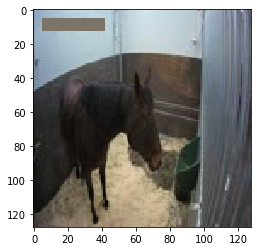

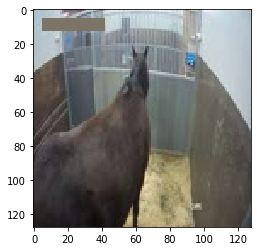

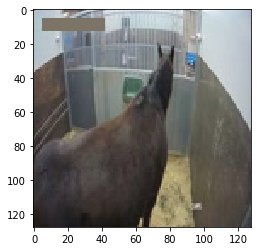

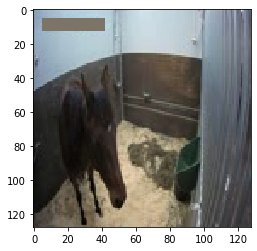

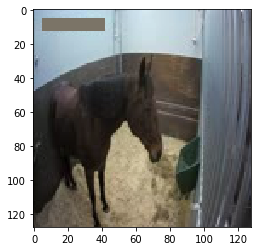

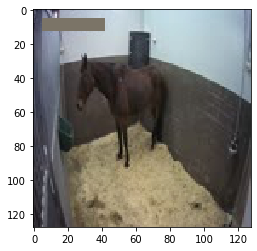

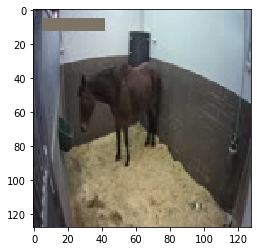

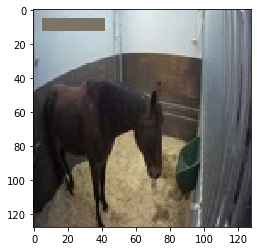

In [46]:
for i in range(8):
    img_tensor = input_dict['img_crop'][i,:]
    img_tensor[:,5:13, 5:42] = 0
    plt.imshow(tensor_to_img(img_tensor))
    plt.show()

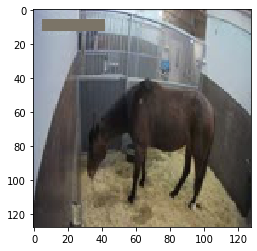

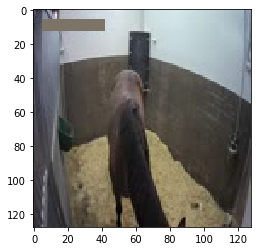

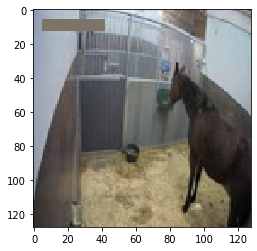

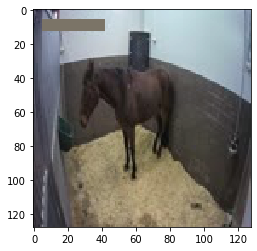

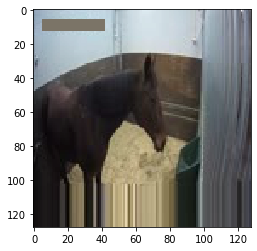

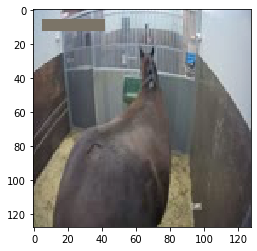

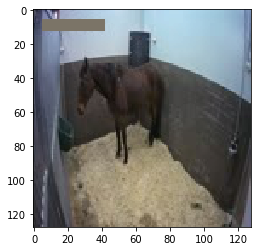

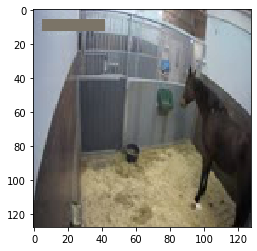

In [42]:
for i in range(8):
    img_tensor = label_dict['img_crop'][i,:]
    img_tensor[:,6:13, 5:42] = 0
    plt.imshow(tensor_to_img(img_tensor))
    plt.show()

## Frames debugging

In [12]:
config_dict_module = multiview_dataset.rhodin_utils_io.loadModule("configs/config_train.py")
config_dict = config_dict_module.config_dict
config_dict['data_dir_path'] = '../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps/'
subjects = ['aslan', 'brava', 'herrera', 'inkasso', 'julia', 'kastanjett', 'naughty_but_nice', 'sir_holger']

# Load entire dataset

dataset = MultiViewDataset(
             data_folder=config_dict['data_dir_path'],
             bg_folder='../data/median_bg/',
             input_types=['img_crop'], label_types=['img_crop'],
             subjects=subjects)

batch_sampler = MultiViewDatasetSampler(
             subjects=subjects,
             data_folder=config_dict['data_dir_path'],
             use_subject_batches=1, use_view_batches=2,
             batch_size=8,
             randomize=True)

trainloader = DataLoader(dataset, batch_sampler=batch_sampler,
                         num_workers=0, pin_memory=False,
                         collate_fn=multiview_dataset.rhodin_utils_datasets.default_collate_with_string)

data_iterator = iter(trainloader)

print('Number of frames in dataset: ', len(dataset))

Iterating over frame indices per subject (.csv files)
Iterating over frame indices per subject (.csv files)


  1%|▏         | 13502/921600 [00:00<00:06, 135010.47it/s]

Establishing sequence association. Available labels: ['Unnamed: 0', 'interval', 'interval_ind', 'view', 'subject', 'pain', 'frame']


100%|██████████| 921600/921600 [00:03<00:00, 272011.42it/s]


DictDataset: Done initializing, listed 230400 viewsets (230400 frames) and 48 sequences


  0%|          | 2/230400 [00:00<4:16:44, 14.96it/s]

Randomizing dataset (MultiViewDatasetSampler.__iter__)


100%|██████████| 230400/230400 [2:13:39<00:00, 28.73it/s]  


Number of frames in dataset:  921600


In [13]:
import os.path
from tqdm import tqdm



def get_image_name(subject, interval_ind, interval, view, frame):                                                                                                                           
    frame_id = '_'.join([subject[:2], '%02d'%interval_ind,                                                                                         
                         str(view), '%06d'%frame])
    return config_dict['data_dir_path'] + '/{}/{}/{}/{}.jpg'.format(subject,                                                                                   
                                                        interval,                                                                                  
                                                        view,                                                                                      
                                                        frame_id) 


# Count missing frames and print the paths of the missing frames, good to have for debugging later on.

subject_counters = []
for subject in subjects:
    print('Subject: ', subject)
    sdf = pd.read_csv(config_dict['data_dir_path'] + subject + '_frame_index.csv')
    subject_counter = 0
    sdf_length = len(sdf)
    with tqdm(total=sdf_length) as pbar:
        for ind, row in sdf.iterrows():
            pbar.update(1)
            interval_ind = row['interval_ind']
            interval = row['interval']
            view = row['view']
            frame = row['frame']
            frame_path = get_image_name(subject, interval_ind, interval, view, frame)
            if not os.path.isfile(frame_path):
                print(frame_path)
                subject_counter += 1
    subject_counters.append(subject_counter)
    
print(subject_counters)

Subject:  aslan


  9%|▊         | 9844/115200 [00:04<00:41, 2529.56it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103122542_130850/1/as_00_1_004390.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103122542_130850/1/as_00_1_004391.jpg


 38%|███▊      | 43689/115200 [00:17<00:28, 2496.33it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103154700_165305/2/as_02_2_006171.jpg


 41%|████      | 46741/115200 [00:19<00:27, 2489.28it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103154700_165305/3/as_02_3_001508.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103154700_165305/3/as_02_3_001509.jpg


 44%|████▎     | 50331/115200 [00:20<00:25, 2563.27it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103154700_165305/3/as_02_3_004906.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190103154700_165305/3/as_02_3_004907.jpg


 61%|██████▏   | 70704/115200 [00:28<00:17, 2574.53it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190104094540_104238/1/as_05_1_004426.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//aslan/20190104094540_104238/1/as_05_1_004427.jpg


100%|██████████| 115200/115200 [00:46<00:00, 2479.94it/s]


Subject:  brava


  5%|▌         | 5969/115200 [00:02<00:43, 2538.11it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102163705_172757/0/br_00_0_005757.jpg


 11%|█▏        | 13015/115200 [00:05<00:42, 2380.29it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102163705_172757/2/br_00_2_000371.jpg


 19%|█▉        | 21745/115200 [00:09<00:37, 2505.88it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102163705_172757/3/br_00_3_002931.jpg


 28%|██▊       | 32378/115200 [00:13<00:32, 2526.23it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/0/br_01_0_007614.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/0/br_01_0_007615.jpg


 33%|███▎      | 37477/115200 [00:15<00:30, 2562.98it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/1/br_01_1_004453.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/1/br_01_1_004454.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/1/br_01_1_004455.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/1/br_01_1_004456.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/1/br_01_1_004457.jpg


 42%|████▏     | 48725/115200 [00:20<00:26, 2538.20it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/2/br_01_2_007345.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/2/br_01_2_007346.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/2/br_01_2_007347.jpg


 49%|████▊     | 56086/115200 [00:23<00:23, 2517.43it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_006514.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_006515.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_006516.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_006517.jpg


 50%|█████     | 57600/115200 [00:23<00:31, 1851.06it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008194.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008195.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008196.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008197.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008198.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008199.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008200.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br_01_3_008201.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181102180200_191108/3/br

 50%|█████     | 58064/115200 [00:24<00:32, 1782.74it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/0/br_02_0_000148.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/0/br_02_0_000149.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/0/br_02_0_000150.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/0/br_02_0_000151.jpg


 57%|█████▋    | 65406/115200 [00:27<00:20, 2428.28it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/1/br_02_1_000146.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/1/br_02_1_000147.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/1/br_02_1_000148.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/1/br_02_1_000149.jpg


 63%|██████▎   | 72471/115200 [00:29<00:17, 2402.39it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/2/br_02_2_000146.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/2/br_02_2_000147.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/2/br_02_2_000148.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/2/br_02_2_000149.jpg


 69%|██████▉   | 79817/115200 [00:32<00:14, 2410.93it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/3/br_02_3_000146.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/3/br_02_3_000147.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/3/br_02_3_000148.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103120024_130024/3/br_02_3_000149.jpg


 83%|████████▎ | 95935/115200 [00:39<00:08, 2321.27it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103143027_145920/2/br_03_2_002206.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//brava/20181103143027_145920/2/br_03_2_002207.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  herrera


  6%|▌         | 6610/115200 [00:02<00:42, 2558.48it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103154700_165305/0/he_00_0_006151.jpg


 12%|█▏        | 13801/115200 [00:05<00:39, 2556.10it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103154700_165305/1/he_00_1_005466.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103154700_165305/1/he_00_1_005467.jpg


 28%|██▊       | 32666/115200 [00:13<00:35, 2315.71it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000567.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000568.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000569.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000570.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000571.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000572.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/0/he_01_0_000573.jpg


 29%|██▉       | 33920/115200 [00:14<00:32, 2489.73it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000567.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000568.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000569.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000570.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000571.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000572.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/1/he_01_1_000573.jpg


 31%|███▏      | 36217/115200 [00:15<00:32, 2460.96it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/3/he_01_3_000562.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/3/he_01_3_000563.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/3/he_01_3_000564.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190103180200_181149/3/he_01_3_000565.jpg


 41%|████      | 47182/115200 [00:32<00:40, 1688.30it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190104094540_102644/1/he_03_1_003896.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190104094540_102644/1/he_03_1_003897.jpg


 53%|█████▎    | 61346/115200 [00:39<00:23, 2251.80it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_05_0_001399.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_05_0_001400.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_05_0_001401.jpg


 59%|█████▊    | 67496/115200 [00:41<00:21, 2182.83it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_05_1_000744.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_05_1_000745.jpg


 62%|██████▏   | 70850/115200 [00:42<00:17, 2575.58it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_05_1_004137.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  inkasso


  5%|▍         | 5507/115200 [00:02<00:43, 2546.35it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004995.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004996.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004997.jpg


 12%|█▏        | 13773/115200 [00:05<00:40, 2505.87it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_013459.jpg


 28%|██▊       | 32217/115200 [00:13<00:35, 2334.03it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003061.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003062.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003063.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003064.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003065.jpg


 41%|████      | 46786/115200 [00:19<00:27, 2477.22it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003159.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003160.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003161.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003162.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003163.jpg


 77%|███████▋  | 88375/115200 [00:38<00:11, 2385.56it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001526.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001527.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001528.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001529.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001530.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001531.jpg


 97%|█████████▋| 111232/115200 [00:48<00:01, 2529.39it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330131405_133019/1/in_04_1_001380.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//inkasso/20190330131405_133019/1/in_04_1_001381.jpg


100%|██████████| 115200/115200 [00:50<00:00, 2289.89it/s]


Subject:  julia


 28%|██▊       | 32744/115200 [00:14<00:32, 2539.95it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003081.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003082.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003083.jpg


 33%|███▎      | 38163/115200 [00:16<00:34, 2204.34it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001301.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001302.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001303.jpg


 38%|███▊      | 43986/115200 [00:18<00:35, 2031.64it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000065.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000066.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000067.jpg


 44%|████▍     | 51239/115200 [00:22<00:37, 1726.31it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000259.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000260.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000261.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000262.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000263.jpg


 86%|████████▌ | 99243/115200 [00:42<00:07, 2178.29it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190329115958_124838/2/ju_04_2_000916.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//julia/20190329115958_124838/2/ju_04_2_000917.jpg


100%|██████████| 115200/115200 [00:49<00:00, 2329.16it/s]


Subject:  kastanjett


 15%|█▌        | 17309/115200 [00:07<00:38, 2544.32it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_154240/3/ka_00_3_003023.jpg


 39%|███▉      | 44929/115200 [00:27<01:41, 694.48it/s] 

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/2/ka_01_2_006506.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/2/ka_01_2_006507.jpg


 49%|████▉     | 56268/115200 [00:31<00:25, 2288.04it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/3/ka_01_3_008044.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/3/ka_01_3_008045.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/3/ka_01_3_008046.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181206180200_192340/3/ka_01_3_008047.jpg


 71%|███████   | 81858/115200 [00:43<00:14, 2288.03it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181208135900_141950/2/ka_04_2_000080.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//kastanjett/20181208135900_141950/2/ka_04_2_000081.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  naughty_but_nice


  3%|▎         | 3770/115200 [00:01<00:49, 2254.33it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/0/na_00_0_003241.jpg


 10%|█         | 11957/115200 [00:05<00:49, 2076.38it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/2/na_00_2_000875.jpg


 17%|█▋        | 19267/115200 [00:08<00:40, 2341.77it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/3/na_00_3_002790.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/3/na_00_3_002791.jpg


 24%|██▍       | 27475/115200 [00:12<00:38, 2264.82it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/1/na_01_1_000995.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/1/na_01_1_000996.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/1/na_01_1_000997.jpg


 32%|███▏      | 36739/115200 [00:16<00:33, 2308.48it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/3/na_01_3_001091.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/3/na_01_3_001092.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_154240/3/na_01_3_001093.jpg


 46%|████▌     | 53091/115200 [00:23<00:25, 2426.29it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206180200_183855/2/na_02_2_004190.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206180200_183855/2/na_02_2_004191.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206180200_183855/2/na_02_2_004192.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206180200_183855/2/na_02_2_004193.jpg


 59%|█████▉    | 67778/115200 [00:30<00:20, 2356.06it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207121215_125556/0/na_04_0_002005.jpg


 65%|██████▌   | 75003/115200 [00:33<00:16, 2490.44it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207121215_125556/1/na_04_1_003879.jpg


 82%|████████▏ | 94783/115200 [00:41<00:08, 2490.36it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207141239_145459/1/na_05_1_003001.jpg


100%|██████████| 115200/115200 [00:50<00:00, 2272.48it/s]


Subject:  sir_holger


  9%|▉         | 10518/115200 [00:04<00:41, 2500.24it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/1/si_00_1_002817.jpg


 12%|█▏        | 13863/115200 [00:06<00:39, 2535.37it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/1/si_00_1_006209.jpg


 14%|█▍        | 15872/115200 [00:07<00:41, 2383.10it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000635.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000636.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000637.jpg


 22%|██▏       | 24930/115200 [00:10<00:35, 2517.47it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002428.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002429.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002430.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002431.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002432.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002433.jpg


 29%|██▊       | 32863/115200 [00:14<00:34, 2406.92it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_172757/0/si_01_0_003087.jpg


 34%|███▎      | 38785/115200 [00:16<00:33, 2294.71it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_172757/1/si_01_1_002857.jpg


 44%|████▍     | 50658/115200 [00:21<00:25, 2498.65it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_172757/3/si_01_3_002481.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_172757/3/si_01_3_002482.jpg
../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_172757/3/si_01_3_002483.jpg


 98%|█████████▊| 113344/115200 [00:49<00:00, 2364.25it/s]

../data/pain_no_pain_x2h_intervals_for_extraction_128_128_2fps//sir_holger/20181104211205_213334/3/si_06_3_000243.jpg


100%|██████████| 115200/115200 [00:49<00:00, 2309.91it/s]

[9, 121, 29, 22, 16, 9, 17, 17]


In [14]:
subject_counters

[9, 121, 29, 22, 16, 9, 17, 17]

In [15]:
sum(subject_counters)

240

In [16]:
import os.path
from tqdm import tqdm

def get_image_name(subject, interval_ind, interval, view, frame):                                                                                                                           
    frame_id = '_'.join([subject[:2], '%02d'%interval_ind,                                                                                         
                         str(view), '%06d'%frame])
    return config_dict['data_dir_path'] + '/{}/{}/{}/{}.jpg'.format(subject,                                                                                   
                                                        interval,                                                                                  
                                                        view,                                                                                      
                                                        frame_id)

# Count missing frames per subjects, and keep track of their indices.
subject_counters = []
subject_dfs = []
subject_missing_inds = []
for subject in subjects:
    
    print('Subject: ', subject)
    sdf = pd.read_csv(config_dict['data_dir_path'] + subject + '_frame_index.csv')
    
    subject_counter = 0
    sdf_length = len(sdf)
    missing_inds = []
    with tqdm(total=sdf_length) as pbar:
        for ind, row in sdf.iterrows():
            pbar.update(1)
            interval_ind = row['interval_ind']
            interval = row['interval']
            view = row['view']
            frame = row['frame']
            frame_path = get_image_name(subject, interval_ind, interval, view, frame)
            if not os.path.isfile(frame_path):
                missing_inds.append(ind)
                subject_counter += 1
                
    subject_missing_inds.append(missing_inds)
    subject_counters.append(subject_counter)
    subject_dfs.append(sdf)

  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  aslan


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  brava


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  herrera


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  inkasso


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  julia


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  kastanjett


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  naughty_but_nice


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  sir_holger


100%|██████████| 115200/115200 [00:45<00:00, 2510.54it/s]

[9, 121, 29, 22, 16, 9, 17, 17]


In [29]:
subject_counters

[9, 121, 29, 22, 16, 9, 17, 17]

In [17]:
copy_as_df = subject_dfs[0]

In [18]:
liltest = copy_as_df.head()
liltest

,Unnamed: 0,interval,interval_ind,view,subject,pain,frame
0,0,20190103122542_130850,0,0,aslan,0,0
1,1,20190103122542_130850,0,0,aslan,0,1
2,2,20190103122542_130850,0,0,aslan,0,2
3,3,20190103122542_130850,0,0,aslan,0,3
4,4,20190103122542_130850,0,0,aslan,0,4


In [19]:
liltest = liltest.drop((liltest.index[[2,3]]))

In [20]:
liltest

,Unnamed: 0,interval,interval_ind,view,subject,pain,frame
0,0,20190103122542_130850,0,0,aslan,0,0
1,1,20190103122542_130850,0,0,aslan,0,1
4,4,20190103122542_130850,0,0,aslan,0,4


In [21]:
liltest.reset_index(drop=True)

,Unnamed: 0,interval,interval_ind,view,subject,pain,frame
0,0,20190103122542_130850,0,0,aslan,0,0
1,1,20190103122542_130850,0,0,aslan,0,1
2,4,20190103122542_130850,0,0,aslan,0,4


In [22]:
len(copy_as_df)

115200

In [23]:
reduced = copy_as_df.drop((copy_as_df.index[subject_missing_inds[0]]))

In [24]:
len(reduced)

115191

In [25]:
(len(copy_as_df) - len(reduced)) == subject_counters[0]

True

In [26]:
reduced_dfs = []
for i in range(8):
    sdf = subject_dfs[i]
    reduced = sdf.drop((sdf.index[subject_missing_inds[i]]))
    reduced = reduced.reset_index(drop=True)
    reduced_dfs.append(reduced)

In [27]:
[(len(subject_dfs[i]) - len(reduced_dfs[i])) == subject_counters[i] for i in range(8)]

[True, True, True, True, True, True, True, True]

In [28]:
for ind, subject in enumerate(subjects):
    reduced_dfs[ind].to_csv(config_dict['data_dir_path'] + subject + '_reduced_frame_index.csv')